<center><h1><b><span style="color:blue">Particles, decays, HEP units</span></b></h1></center>

&nbsp;<br>
### **Quick intro to the following packages**
- `hepunits` - the HEP system of units.
- `Particle` - PDG particle data, MC identification codes, and more.
- `DecayLanguage` - Decay files (notably for EvtGen), universal description of decay chains.

<center><h2><b><span style="color:green">hepunits - The HEP system of units</span></b></h2></center>

The package ``hepunits`` collects the most commonly used units and constants in the
HEP System of Units, which are *not* the same as the international system of units (aka SI units).
The HEP system of units is based on the following:

| Quantity            | Name               | Unit|
| ------------------ :| ----------------- :| -- :|
|  Length             |  millimeter        | mm  |
|  Time               |  nanosecond        | ns  |
|  Energy             |  Mega electron Volt| MeV |
|  Positron charge    |  eplus             |     |
|  Temperature        |  kelvin            | K   |
|  Amount of substance|  mole              | mol |
|  Luminous intensity |  candela           | cd  |
| Plane angle         |  radian            | rad |
|  Solid angle        |  steradian         | sr  |

Note: no need to make use of sophisticated packages (e.g. as in AstroPy) since we basically never need to change systems of units (we never use ergs as energy, for example ;-)).

**Basic usage is straightforward, though it may be confusing at first. Remember, all variables are written wrt to the units:**

In [1]:
from hepunits import mm, ns, MeV, eplus, GeV, kelvin, mol, cd, rad, sr

mm == ns == MeV == eplus == kelvin == mol == cd == rad == sr == 1

True

In [2]:
GeV == 1000*MeV

True

Add two quantities with different length units:

In [3]:
from hepunits import units as u

1*u.meter + 5*u.cm

1050.0

Indeed, the result is in HEP units, so mm. Rather obtain the result in meters:

In [4]:
(1*u.meter + 5*u.cm) / u.meter

1.05

Do you need to play a bit more to get a proper feeling? This next (non-academic) exercise should help you ...

### **Quick time-of-flight study**

Let's try to play with units in a meaningful way, in a kind of exercise that physicists encounter. Imagine you are investigating time-of-flight (ToF) detectors for particle identification. The time it takes a particle of velocity $\beta = v/c= pc/E$ to travel a distance $L$ is given by

$$\mathrm{ToF} = \frac{L}{c \beta}$$

It results that the mass $m$ of the particle can be determined from

$$m = \frac{p}{c}\sqrt{\frac{c^2 \mathrm{ToF}^2}{L^2}-1}$$

provided the path length and the momentum can be measured, say, by a tracking system.

What are typical ToF differences say for (charged) kaons and pions?
It is practical to perform the calculation as

$$\Delta \mathrm{ToF} = \frac{L}{c}(\frac{1}{\beta_1} - \frac{1}{\beta_2})\,,$$

with $\frac{1}{\beta} = \sqrt{1+m^2c^2/p^2}$.

In [5]:
from hepunits import c_light, GeV, meter, ps, ns

import numpy as np

def ToF(m, p, L):
    """Time-of-Flight = particle path length L / (c * beta)"""
    # No c factors here because physicists give m and p without them, hence the c's cancel out, effectively ;-).
    one_over_beta = np.sqrt(1 + m*m/(p*p))
    return (L * one_over_beta /c_light)

For convenience, get hold of data information for the proton, $K^+$ and $\pi^+$ (see `Particle`package down this notebook):

In [6]:
from particle.particle.literals import proton, pi_plus, K_plus  # particle name literals

Calculate the difference in ToF between 10 GeV kaons and pions travelling over 10 meters:

In [7]:
delta = ( ToF(K_plus.mass, 10*GeV, 10*meter) - ToF(pi_plus.mass, 10*GeV, 10*meter) ) / ps
print("At 10 GeV, Delta-TOF(K-pi) over 10 meters = {:.5} ps".format(delta))

At 10 GeV, Delta-TOF(K-pi) over 10 meters = 37.374 ps


Let's get a bit fancier:
- Compare protons, kaons and pions for a 1-meter path length.
- Look at the ToF difference versus momentum.
Other plotting tools (from HEP, actually) will be presented later on. For now let's just use the standard `matplotlib` library.

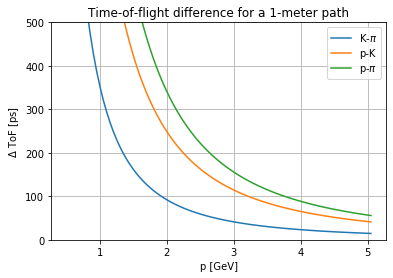

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

p = np.arange(0.5, 5.1, 0.05) * GeV

# Calculate all the delta-ToF in picoseconds
delta1 = ( ToF(K_plus.mass, p, 1.*meter) - ToF(pi_plus.mass, p, 1.*meter) ) / ps
delta2 = ( ToF(proton.mass, p, 1.*meter) - ToF(K_plus.mass, p, 1.*meter) ) / ps
delta3 = ( ToF(proton.mass, p, 1.*meter) - ToF(pi_plus.mass, p, 1.*meter) ) / ps

fig, ax = plt.subplots()
ax.plot(p/GeV, delta1, label='K-$\pi$')
ax.plot(p/GeV, delta2, label='p-K')
ax.plot(p/GeV, delta3, label='p-$\pi$')

ax.set(xlabel='p [GeV]', ylabel='$\Delta$ ToF [ps]',
       title='Time-of-flight difference for a 1-meter path')
ax.grid()

plt.legend()
plt.ylim(bottom=0, top=500)
plt.show()

&nbsp;
<center><img src="images/logo_particle.png" alt="Particle package logo" style="width: 150px;"/></center>

<center><h2><b><span style="color:green">PDG particle data, MC identification codes</span></b></h2></center>

### **Pythonic interface to**
- Particle Data Group (PDG) particle data table.
- Particle MC identification codes, with inter-MC converters.
- With various extra goodies.

### Package motivation - particle data

- The [PDG](http://pdg.lbl.gov/) provides a <span style="color:green">downloadable table of particle masses, widths, charges and Monte Carlo particle ID numbers</span> (PDG IDs).
  - Most recent file [here](http://pdg.lbl.gov/2020/html/computer_read.html).
- It <span style="color:green">also provided an experimental file with extended information</span>
(spin, quark content, P and C parities, etc.) until 2008 only, see [here](http://pdg.lbl.gov/2008/html/computer_read.html) (not widely known!).

- But <span style="color:green"><i>anyone</i> wanting to use these data</span>, the only readily available,
<span style="color:green">has to parse the file programmatically</span>.
- Why not make a Python package to deal with all these data, for everyone?

### Package motivation - MC identification codes

- The <span style="color:green">C++ HepPID and HepPDT libraries provide functions for processing particle ID codes</apan>
in the standard particle (aka PDG) numbering scheme.
- Different event generators may have their separate set of particle IDs: Geant3, etc.
- Again, why not make a package providing all functionality/conversions, Python-ically, for everyone?

### Package, in short

- <span style="color:green">Particle</span> - loads extended <b>PDG data tables</b> and implements search and manipulations / display.
- <span style="color:green">PDGID</span> - find out as much as possible from the PDG ID number. <b>No table lookup</b>.
- <span style="color:green">Converters for MC IDs</span> used in Pythia and Geant.
- Basic usage via the command line.
- Fexible / advanced usage programmatically.

### **1. `PDGID` class and MC ID classes**


- Classes `PDGID`, `PythiaID`, `Geant3ID`.
- Converters in module `particle.converters`: `Geant2PDGIDBiMap`, etc.

#### PDG IDs module overview

- <span style="color:green">Process and query PDG IDs</span>, and more – no look-up table needed.
  - Current version of package reflects the latest version of the
    <span style="color:green">HepPID & HepPDT utility functions</span> defined in the C++ HepPID and HepPDT versions 3.04.01
  - It contains more functionality than that available in the C++ code … and minor fixes too.
- Definition of a <span style="color:green">PDGID class, PDG ID literals</span>,
and set of standalone HepPID <span style="color:green">functions to query PDG IDs</span>
(is_meson, has_bottom, j_spin, charge, etc.).
   - All PDGID class functions are available standalone.

#### PDGID class
- Wrapper class `PDGID` for PDG IDs.
- Behaves like an int, with extra goodies.
- Large spectrum of properties and methods, with a Pythonic interface, and yet more!

In [9]:
from particle import PDGID

In [10]:
pid = PDGID(211)
pid

<PDGID: 211>

In [11]:
PDGID(99999999)

<PDGID: 99999999 (is_valid==False)>

In [12]:
from particle.pdgid import is_meson

pid.is_meson, is_meson(pid)

(True, True)

To print all `PDGID` properties:

In [13]:
print(pid.info())

A              None
J              0.0
L              0
S              0
Z              None
abspid         211
charge         1.0
has_bottom     False
has_charm      False
has_down       True
has_fundamental_anti False
has_strange    False
has_top        False
has_up         True
is_Qball       False
is_Rhadron     False
is_SUSY        False
is_baryon      False
is_composite_quark_or_lepton False
is_diquark     False
is_dyon        False
is_gauge_boson_or_higgs False
is_generator_specific False
is_hadron      True
is_lepton      False
is_meson       True
is_nucleus     False
is_pentaquark  False
is_quark       False
is_sm_gauge_boson_or_higgs False
is_special_particle False
is_technicolor False
is_valid       True
j_spin         1
l_spin         1
s_spin         1
three_charge   3



#### MC ID classes and converters

- <span style="color:green">Classes for MC IDs</span> used in Pythia and Geant3: `PythiaID` and `Geant3ID`.
- <span style="color:green">ID converters</span> in module `particle.converters`: `Geant2PDGIDBiMap`, etc.

In [14]:
from particle import PythiaID, Geant3ID

pyid = PythiaID(10221)

pyid.to_pdgid()

<PDGID: 9010221>

Conversions are directly available via mapping classes.

E.g., bi-directional map Pythia ID - PDG ID:

In [15]:
from particle.converters import Pythia2PDGIDBiMap

Pythia2PDGIDBiMap[PDGID(9010221)]

<PythiaID: 10221>

In [16]:
Pythia2PDGIDBiMap[PythiaID(10221)]

<PDGID: 9010221>

### **2. `Particle` class**

There are various ways to create a particle. The often used method is via its PDG ID.

In [17]:
from particle import Particle

In [18]:
Particle.from_pdgid(211)

<Particle: name="pi+", pdgid=211, mass=139.57039 ± 0.00018 MeV>

**Searching**

<span style="color:green">Simple and natural API</span> to deal with the PDG particle data table,<br>with <span style="color:green">powerful 1-line search and look-up utilities!</span>

- `Particle.find(…)` – search a single match (exception raised if multiple particles match the search specifications).
- `Particle.findall(…)` – search a list of candidates.

- Search methods that can query any particle property!

In [19]:
Particle.find('J/psi')

<Particle: name="J/psi(1S)", pdgid=443, mass=3096.900 ± 0.006 MeV>

You can specify search terms as keywords - _any particle property_:

In [20]:
Particle.find(latex_name=r'\phi(1020)')

<Particle: name="phi(1020)", pdgid=333, mass=1019.461 ± 0.016 MeV>

You can directly check the numeric charge:

In [21]:
Particle.findall('pi', charge=-1)

[<Particle: name="pi-", pdgid=-211, mass=139.57039 ± 0.00018 MeV>,
 <Particle: name="pi(2)(1670)-", pdgid=-10215, mass=1670.6 + 2.9 - 1.2 MeV>,
 <Particle: name="pi(1300)-", pdgid=-100211, mass=1300 ± 100 MeV>,
 <Particle: name="pi(1)(1400)-", pdgid=-9000213, mass=1354 ± 25 MeV>,
 <Particle: name="pi(1800)-", pdgid=-9010211, mass=1810 + 9 - 11 MeV>,
 <Particle: name="pi(1)(1600)-", pdgid=-9010213, mass=1660 + 15 - 11 MeV>]

Or use a **lambda function** for the ultimate in generality! For example, to find all the neutral particles with a bottom quark between 5.2 and 5.3 GeV:

In [22]:
from hepunits import GeV, s  # Units are good. Use them.

In [23]:
Particle.findall(lambda p:
                     p.pdgid.has_bottom
                     and p.charge==0
                     and 5.2*GeV < p.mass < 5.3*GeV
                )

[<Particle: name="B0", pdgid=511, mass=5279.65 ± 0.12 MeV>,
 <Particle: name="B~0", pdgid=-511, mass=5279.65 ± 0.12 MeV>]

Another lambda function example: You can use the width or the lifetime:

In [24]:
Particle.findall(lambda p: p.lifetime > 1000*s)

[<Particle: name="e-", pdgid=11, mass=0.510998946 ± 0.000000003 MeV>,
 <Particle: name="e+", pdgid=-11, mass=0.510998946 ± 0.000000003 MeV>,
 <Particle: name="g", pdgid=21, mass=0.0 MeV>,
 <Particle: name="gamma", pdgid=22, mass=0.0 MeV>,
 <Particle: name="p", pdgid=2212, mass=938.272081 ± 0.000006 MeV>,
 <Particle: name="p~", pdgid=-2212, mass=938.272081 ± 0.000006 MeV>,
 <Particle: name="p", pdgid=1000010010, mass=938.272081 ± 0.000006 MeV>,
 <Particle: name="p~", pdgid=-1000010010, mass=938.272081 ± 0.000006 MeV>]

If you want infinite lifetime, you could just use the keyword search instead:

In [25]:
Particle.findall(lifetime=float('inf'))

[<Particle: name="e-", pdgid=11, mass=0.510998946 ± 0.000000003 MeV>,
 <Particle: name="e+", pdgid=-11, mass=0.510998946 ± 0.000000003 MeV>,
 <Particle: name="g", pdgid=21, mass=0.0 MeV>,
 <Particle: name="gamma", pdgid=22, mass=0.0 MeV>,
 <Particle: name="p", pdgid=2212, mass=938.272081 ± 0.000006 MeV>,
 <Particle: name="p~", pdgid=-2212, mass=938.272081 ± 0.000006 MeV>,
 <Particle: name="p", pdgid=1000010010, mass=938.272081 ± 0.000006 MeV>,
 <Particle: name="p~", pdgid=-1000010010, mass=938.272081 ± 0.000006 MeV>]

Trivially find all pseudoscalar charm mesons:

In [26]:
from particle import SpinType

Particle.findall(lambda p: p.pdgid.is_meson and p.pdgid.has_charm and p.spin_type==SpinType.PseudoScalar)

[<Particle: name="D+", pdgid=411, mass=1869.65 ± 0.05 MeV>,
 <Particle: name="D-", pdgid=-411, mass=1869.65 ± 0.05 MeV>,
 <Particle: name="D0", pdgid=421, mass=1864.83 ± 0.05 MeV>,
 <Particle: name="D~0", pdgid=-421, mass=1864.83 ± 0.05 MeV>,
 <Particle: name="D(s)+", pdgid=431, mass=1968.34 ± 0.07 MeV>,
 <Particle: name="D(s)-", pdgid=-431, mass=1968.34 ± 0.07 MeV>,
 <Particle: name="eta(c)(1S)", pdgid=441, mass=2983.9 ± 0.5 MeV>,
 <Particle: name="B(c)+", pdgid=541, mass=6274.9 ± 0.8 MeV>,
 <Particle: name="B(c)-", pdgid=-541, mass=6274.9 ± 0.8 MeV>,
 <Particle: name="eta(c)(2S)", pdgid=100441, mass=3637.5 ± 1.1 MeV>]

**Display**

Nice display in Jupyter notebooks, as well as `str` and `repr` support:

In [27]:
p = Particle.from_pdgid(-415)
p

<Particle: name="D(2)*(2460)-", pdgid=-415, mass=2465.4 ± 1.3 MeV>

In [28]:
print(p)

D(2)*(2460)-


In [29]:
print(repr(p))

<Particle: name="D(2)*(2460)-", pdgid=-415, mass=2465.4 ± 1.3 MeV>


Full descriptions:

In [30]:
print(p.describe())

Name: D(2)*(2460)-   ID: -415         Latex: $D_{2}^{*}(2460)^{-}$
Mass  = 2465.4 ± 1.3 MeV
Width = 46.7 ± 1.2 MeV
Q (charge)        = -       J (total angular) = 2.0      P (space parity) = +
C (charge parity) = None    I (isospin)       = 0.5      G (G-parity)     = None
    SpinType: SpinType.Tensor
    Quarks: Cd
    Antiparticle name: D(2)*(2460)+ (antiparticle status: ChargeInv)


You may find LaTeX or HTML to be more useful in your program; both are supported:

In [31]:
print(p.latex_name, '\n', p.html_name)

D_{2}^{*}(2460)^{-} 
 D<SUB>2</SUB><SUP>*</SUP>(2460)<SUP>-</SUP>


**Particle properties**

You can do things to particles, like **invert** them:

In [32]:
~p

<Particle: name="D(2)*(2460)+", pdgid=415, mass=2465.4 ± 1.3 MeV>

There are a plethora of properties you can access:

In [33]:
p.spin_type

<SpinType.Tensor: 3>

You can quickly access the PDGID of a particle:

In [34]:
p.pdgid

<PDGID: -415>

### **3. Literals**

They provide a <span style="color:green">handy way to manipulate things with human-readable names!</span>

`Particle` defines <span style="color:green">literals for most common particles</span>, with easily recognisable names.
- Literals are dynamically generated on import for both `PDGID` and `Particle` classes.

**PDGID literals**

In [35]:
from particle.pdgid import literals as lid

In [36]:
lid.phi_1020

<PDGID: 333>

**Particle literals**

In [37]:
from particle import literals as lp

In [38]:
lp.phi_1020

<Particle: name="phi(1020)", pdgid=333, mass=1019.461 ± 0.016 MeV>

### **4. Data files, stored in `particle/data/`**

- <b>PDG particle data files</b>
  - Original PDG data files, which are in a fixed-width format - simply for bookkeeping and reference.
  - Code rather uses “digested forms” of these, produced within `Particle`, stored as CSV, for optimised querying.
  - Latest PDG data (2020) used by default.
  - Advanced usage: user can load older PDG tables, load a “user table” with new particles, append to default table.

- <b>Other data files</b>
  - CSV file for mapping of PDG IDs to particle LaTeX names.

**Dump table contents**

The package provides the 2 methods `Particle.to_dict(...)` and `Particle.to_list(...)`, which make it easy to dump (selected) particle properties in an easy way. No need to dig into the package installation directory to inspect the particle data table ;-).

Tabular output can be formatted with the powerful package `tabulate`, for example (other similar libraries exist).

In [39]:
help(Particle.to_dict)

Help on method to_dict in module particle.particle.particle:

to_dict(*args, **kwargs) method of builtins.type instance
    Render a search (via `findall`) on the internal particle data CSV table
    as a `dict`, loading the table from the default location if no table has yet been loaded.
    
    The returned attributes are those of the class. By default all attributes
    are used as fields. Their complete list is:
        pdgid
        pdg_name
        mass
        mass_upper
        mass_lower
        width
        width_upper
        width_lower
        three_charge
        I
        G
        P
        C
        anti_flag
        rank
        status
        quarks
        latex_name
    
    It is possible to add as returned fields any `Particle` class property,
    e.g. 'name', `J` or `ctau`, see examples below.
    
    Parameters
    ----------
    exclusive_fields: list, optional, default is []
        Exclusive list of fields to print out,
        which can be any `Particle`

In [40]:
from tabulate import tabulate

In [41]:
fields = ['pdgid', 'pdg_name', 'mass', 'mass_upper', 'mass_lower', 'three_charge']
query_as_dict = Particle.to_dict(exclusive_fields=fields, n_rows=10)
print(tabulate(query_as_dict, headers='keys'))

  pdgid  pdg_name       mass    mass_upper    mass_lower    three_charge
-------  ----------  -------  ------------  ------------  --------------
      1  d              4.67           0.5           0.2              -1
     -1  d              4.67           0.5           0.2               1
      2  u              2.16           0.5           0.3               2
     -2  u              2.16           0.5           0.3              -2
      3  s             93             11             5                -1
     -3  s             93             11             5                 1
      4  c           1270             20            20                 2
     -4  c           1270             20            20                -2
      5  b           4180             30            20                -1
     -5  b           4180             30            20                 1


Be fancy - table with all pseudoscalar charm hadrons, in _reStructuredText_ format:

In [42]:
fields = ['pdgid', 'name', 'evtgen_name', 'mass', 'mass_upper', 'mass_lower', 'three_charge']

query_as_dict = Particle.to_dict(filter_fn=lambda p: p.pdgid.is_meson and p.pdgid.has_charm and p.spin_type==SpinType.PseudoScalar,
                                 exclusive_fields=fields)
print(tabulate(query_as_dict, headers='keys', tablefmt='rst'))

=======  ==========  =============  =======  ============  ============  ==============
  pdgid  name        evtgen_name       mass    mass_upper    mass_lower    three_charge
=======  ==========  =============  =======  ============  ============  ==============
    411  D+          D+             1869.65          0.05          0.05               3
   -411  D-          D-             1869.65          0.05          0.05              -3
    421  D0          D0             1864.83          0.05          0.05               0
   -421  D~0         anti-D0        1864.83          0.05          0.05               0
    431  D(s)+       D_s+           1968.34          0.07          0.07               3
   -431  D(s)-       D_s-           1968.34          0.07          0.07              -3
    441  eta(c)(1S)  eta_c          2983.9           0.5           0.5                0
    541  B(c)+       B_c+           6274.9           0.8           0.8                3
   -541  B(c)-       B_c-       

Notebook-friendly HTML is just as easy:

In [43]:
from IPython.display import HTML

query_as_dict = Particle.to_dict(filter_fn=lambda p: p.pdgid.is_meson and p.pdgid.has_charm and p.spin_type==SpinType.PseudoScalar,
                                 exclusive_fields=['pdgid', 'pdg_name', 'html_name'])
HTML(tabulate(query_as_dict, headers='keys', tablefmt='html'))

pdgid,pdg_name,html_name
411,D,D+
-411,D,D-
421,D,D0
-421,D,D̅0
431,D(s),Ds+
-431,D(s),Ds-
441,eta(c)(1S),ηc(1S)
541,B(c),Bc+
-541,B(c),Bc-
100441,eta(c)(2S),ηc(2S)


### **5. Advanced usage**

You can:

* Extend or replace the default particle data table in `Particle`.
* Adjust properties for a particle.
* Make custom particles.

&nbsp;<br>
<center>
    <img src="images/logo_decaylanguage.png" alt="DecayLanguage package logo" style="width: 200px;"/>
    <h2><b><span style="color:green">Decay files, universal description of decay chains</span></b></h2>
</center>

`DecayLanguage` is designed for the manipulation of decay structures in Python. The current package has:

- Decay file parsers:
  - Read *.dec DecFiles*, such as EvtGen decay files typically used in Flavour Physics experiments.
  - Manipulate and visualise them in Python.
- Amplitude Analysis decay language:
  - Input based on AmpGen generator, output format for GooFit C++ program.

### Package motivation

- Ability to describe decay-tree-like structures.
- Provide a translation of decay amplitude models from AmpGen to GooFit.
  - Idea is to generalise this to other decay descriptions.
- Any experiment uses event generators which, among many things, need to describe particle decay chains.
- Programs such as EvtGen rely on so-called .dec decay files.
- Many experiments need decay data files.
- Why not make a Python package to deal with decay files, for everyone?

### Package, in short

- Tools to parse decay files and programmatically manipulate them, query, display information.
  - Descriptions and parsing built atop the [Lark parser](https://github.com/lark-parser/lark/).
- Tools to translate decay amplitude models from AmpGen to GooFit, and manipulate them.

### **1. Decay files**

#### *Master file” DECAY.DEC

<span style="color:green">Gigantic file defining decay modes for all relevant particles, including decay model specifications.</span>
LHCb uses one. Belle II as well, and others.

#### User .dec files
- Needed to produce specific MC samples.
- Typically contain a single decay chain (except if defining inclusive samples).

**Example user decay file:**

<small>
<pre>
# Decay file for [B_c+ -> (B_s0 -> K+ K-) pi+]cc

Alias      B_c+sig        B_c+
Alias      B_c-sig        B_c-
ChargeConj B_c+sig        B_c-sig
Alias      MyB_s0         B_s0
Alias      Myanti-B_s0    anti-B_s0
ChargeConj MyB_s0         Myanti-B_s0

Decay B_c+sig
  1.000     MyB_s0     pi+     PHOTOS PHSP;
Enddecay
CDecay B_c-sig

Decay MyB_s0
    1.000     K+     K-     SSD_CP 20.e12 0.1 1.0 0.04 9.6 -0.8 8.4 -0.6;
Enddecay
CDecay Myanti-B_s0
</pre>
</small>

### **2. Decay file parsing**

- **Parsing should be simple**
  - Expert users can configure parser choice and settings, etc. 
- **Parsing should be (reasonably) fast!**

After parsing, many queries are possible!

In [44]:
from decaylanguage import DecFileParser

#### The LHCb "master decay file"

It's a big file! ~ 500 particle decays defined, thousands of decay modes, over 11k lines in total.

In [45]:
dfp = DecFileParser('data/DECAY_LHCB.DEC')

In [46]:
%%time
dfp.parse()

Wall time: 2.17 s


In [47]:
dfp

<DecFileParser: decfile(s)=['data/DECAY_LHCB.DEC'], n_decays=506>

Let's parse and play with a small decay file:

In [48]:
with open('data/Dst.dec') as f:
    print(f.read())

# Example decay chain for testing purposes
# Considered by itself, this file in in fact incomplete,
# as there are no instructions on how to decay the anti-D0 and the D-!

Decay D*+
0.6770    D0  pi+                    VSS;
0.3070    D+  pi0                    VSS;
0.0160    D+  gamma                  VSP_PWAVE;
Enddecay

Decay D*-
0.6770    anti-D0  pi-                VSS;
0.3070    D-       pi0                VSS;
0.0160    D-       gamma              VSP_PWAVE;
Enddecay

Decay D0
1.0   K-      pi+                  PHSP;
Enddecay

Decay D+
1.0   K-   pi+   pi+   pi0    PHSP;
Enddecay

Decay pi0
0.988228297   gamma   gamma                   PHSP;
0.011738247   e+      e-      gamma           PI0_DALITZ;
0.000033392   e+      e+      e-      e-      PHSP;
0.000000065   e+      e-                      PHSP;
Enddecay



In [49]:
dfp_Dst = DecFileParser('data/Dst.dec')
dfp_Dst

<DecFileParser: decfile(s)=['data/Dst.dec']>

In [50]:
dfp_Dst.parse()
dfp_Dst

<DecFileParser: decfile(s)=['data/Dst.dec'], n_decays=5>

It can be handy to **parse from a multi-line string** rather than a file:

In [51]:
s = """
# Decay file for [B_c+ -> (B_s0 -> K+ K-) pi+]cc

Alias      B_c+sig        B_c+
Alias      B_c-sig        B_c-
ChargeConj B_c+sig        B_c-sig
Alias      MyB_s0         B_s0
Alias      Myanti-B_s0    anti-B_s0
ChargeConj MyB_s0         Myanti-B_s0

Decay B_c+sig
  1.000     MyB_s0     pi+     PHOTOS PHSP;
Enddecay
CDecay B_c-sig

Decay MyB_s0
    1.000     K+     K-     SSD_CP 20.e12 0.1 1.0 0.04 9.6 -0.8 8.4 -0.6;
Enddecay
CDecay Myanti-B_s0
"""

In [52]:
dfp = DecFileParser.from_string(s)
dfp.parse()
dfp

<DecFileParser: decfile(s)=<dec file input as a string>, n_decays=4>

#### Decay file information

In [53]:
dfp_Dst.print_decay_modes('D*+')

       0.677 : D0  pi+                                                        VSS 
       0.307 : D+  pi0                                                        VSS 
       0.016 : D+  gamma                                                VSP_PWAVE 


In [54]:
dfp_Dst.list_decay_mother_names()

['D*+', 'D*-', 'D0', 'D+', 'pi0']

In [55]:
dfp_Dst.list_decay_modes('D*+')

[['D0', 'pi+'], ['D+', 'pi0'], ['D+', 'gamma']]

#### Info such as particle aliases

In [56]:
dfp.dict_aliases()

{'B_c+sig': 'B_c+',
 'B_c-sig': 'B_c-',
 'MyB_s0': 'B_s0',
 'Myanti-B_s0': 'anti-B_s0'}

In [57]:
dfp.dict_charge_conjugates()

{'B_c+sig': 'B_c-sig', 'MyB_s0': 'Myanti-B_s0'}

### **3.  Display of decay chains**

The parser can provide a simple `dict` representation of any decay chain found in the input decay file(s). Being generic and simple, that is what is used as input information for the viewer class (see below).

In [58]:
dc = dfp_Dst.build_decay_chains('D+')
dc

{'D+': [{'bf': 1.0,
   'fs': ['K-',
    'pi+',
    'pi+',
    {'pi0': [{'bf': 0.988228297,
       'fs': ['gamma', 'gamma'],
       'model': 'PHSP',
       'model_params': ''},
      {'bf': 0.011738247,
       'fs': ['e+', 'e-', 'gamma'],
       'model': 'PI0_DALITZ',
       'model_params': ''},
      {'bf': 3.3392e-05,
       'fs': ['e+', 'e+', 'e-', 'e-'],
       'model': 'PHSP',
       'model_params': ''},
      {'bf': 6.5e-08,
       'fs': ['e+', 'e-'],
       'model': 'PHSP',
       'model_params': ''}]}],
   'model': 'PHSP',
   'model_params': ''}]}

In [59]:
from decaylanguage import DecayChainViewer

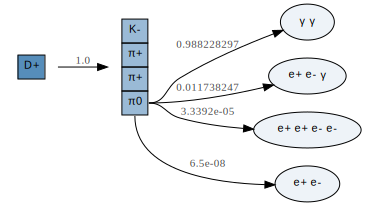

In [60]:
DecayChainViewer(dc)

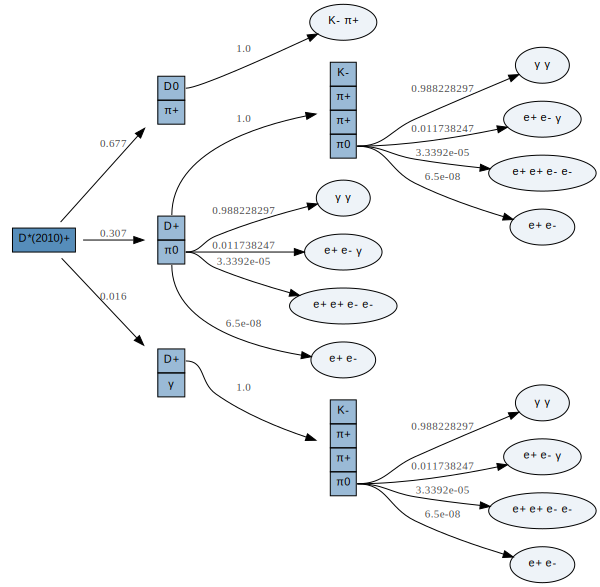

In [61]:
DecayChainViewer(dfp_Dst.build_decay_chains('D*+'))

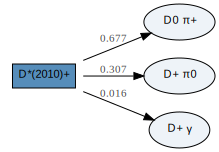

In [62]:
dc = dfp_Dst.build_decay_chains('D*+', stable_particles=['D+', 'D0', 'pi0'])
DecayChainViewer(dc)

#### **Charge conjugation**

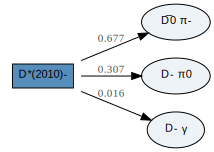

In [63]:
dc_cc = dfp_Dst.build_decay_chains('D*-', stable_particles=['D-', 'anti-D0', 'pi0'])
DecayChainViewer(dc_cc)

#### **Parsing several files**

Typically useful when the user decay file needs information from the master decay file.

In [64]:
s = u"""
Alias      MyXic+              Xi_c+
Alias      MyantiXic-          anti-Xi_c-
ChargeConj MyXic+              MyantiXic-

Decay Xi_cc+sig
  1.000       MyXic+    pi-    pi+       PHSP;
Enddecay
CDecay anti-Xi_cc-sig

Decay MyXic+
  1.000       p+    K-    pi+       PHSP;
Enddecay
CDecay MyantiXic-

End
"""

In [65]:
dfp = DecFileParser.from_string(s)
dfp.parse()
dfp

C:\home\sw\Anaconda3\lib\site-packages\decaylanguage\dec\dec.py:447: UserWarning: 
Corresponding 'Decay' statement for 'CDecay' statement(s) of following particle(s) not found:
anti-Xi_cc-sig.
Skipping creation of these charge-conjugate decay trees.
  warnings.warn(msg)


<DecFileParser: decfile(s)=<dec file input as a string>, n_decays=3>

Note the subtletly: 3, not 4 decays, are found! This is because the file contains no statement
`ChargeConj anti-Xi_cc-sigXi_cc+sig`, hence the parser cannot know to which particle (matching `Decay` statement) the charge-conjugate decay of `anti-Xi_cc-sig` relates to (code does not rely on position of statements to guess ;-)).

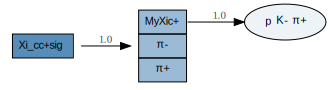

In [66]:
d = dfp.build_decay_chains('Xi_cc+sig')
DecayChainViewer(d)

As said in the warning, the information provided is not enough for the anti-Xi_cc-sig to make sense:

In [67]:
from decaylanguage.dec.dec import DecayNotFound

try:
    d = dfp.build_decay_chains('anti-Xi_cc-sig')
except DecayNotFound:
    print("Decays of particle 'anti-Xi_cc-sig' not found in .dec file!")

Decays of particle 'anti-Xi_cc-sig' not found in .dec file!


But the missing information is easily providing **parsing two files simultaneously ...!** (Any number of files is allowed.)

In [68]:
from tempfile import NamedTemporaryFile

with NamedTemporaryFile(delete=False) as tf:
    tf.write(s.encode('utf-8'))
    
dfp = DecFileParser(tf.name, 'data/DECAY_LHCB.DEC')
dfp.parse()

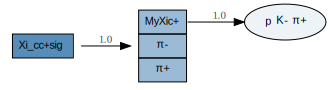

In [69]:
dc = dfp.build_decay_chains('Xi_cc+sig')

DecayChainViewer(dc)

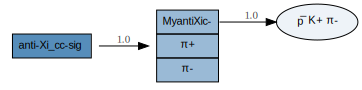

In [70]:
dc_cc = dfp.build_decay_chains('anti-Xi_cc-sig')

DecayChainViewer(dc_cc)

Want to save a graph? Try for example 
```python
dcv = DecayChainViewer(...)
dcv.graph.write_pdf('test.pdf')
```

### **4. Representation of decay chains**

<span style="color:green">The universal (and digital) representation of decay chains is of interest well outside the context of decay file parsing!</span>

#### Building blocks

- A <span style="color:green">daughters list</span> - list of final-state particles.
- A <span style="color:green">decay mode</span> - typically a branching fraction and a list of final-state particles (may also contain _any_ metadata such as decay model and optional decay-model parameters, as defined for example in .dec decay files).
- A <span style="color:green">decay chain</span> - can be seen as a mother particle and a list of decay modes.

In [71]:
from decaylanguage.decay.decay import DaughtersDict, DecayMode, DecayChain

**Daughters list** (actually a ``Counter`` dictionary, internally):

In [72]:
# Constructor from a dictionary
dd = DaughtersDict({'K+': 1, 'K-': 2, 'pi+': 1, 'pi0': 1})

# Constructor from a list of particle names
dd = DaughtersDict(['K+', 'K-', 'K-', 'pi+', 'pi0'])

# Constructor from a string representing the final state
dd = DaughtersDict('K+ K- pi0')
dd

<DaughtersDict: ['K+', 'K-', 'pi0']>

#### Decay Modes

In [73]:
# A 'default' and hence empty, decay mode
dm = DecayMode()

# Decay mode with minimal input information
dd = DaughtersDict('K+ K-')
dm = DecayMode(0.5, dd)

# Decay mode with decay model information and user metadata
dm = DecayMode(0.2551,                                              # branching fraction
               'pi- pi0 nu_tau',                                    # final-state particles
               model='TAUHADNU',                                    # decay model
               model_params=[-0.108, 0.775, 0.149, 1.364, 0.400],   # decay-model parameters
               study='toy', year=2019                               # user metadata
              )
dm

<DecayMode: daughters=nu_tau pi- pi0, BF=0.2551>

In [74]:
print(dm.describe())

Daughters: pi- pi0 nu_tau , BF: 0.2551         
    Decay model: TAUHADNU [-0.108, 0.775, 0.149, 1.364, 0.4]
    Extra info:
        study: toy
        year: 2019



Various manipulations are available:

In [75]:
dm = DecayMode.from_pdgids(0.5, [321, -321])
print(dm)

dm = DecayMode(1.0, 'K+ K+ pi-')
dm.charge_conjugate()

<DecayMode: daughters=K+ K-, BF=0.5>


<DecayMode: daughters=K- K- pi+, BF=1.0>

#### Decay chains 

In [76]:
dm1 = DecayMode(0.0124, 'K_S0 pi0', model='PHSP')
dm2 = DecayMode(0.692, 'pi+ pi-')
dm3 = DecayMode(0.98823, 'gamma gamma')
dc = DecayChain('D0', {'D0':dm1, 'K_S0':dm2, 'pi0':dm3})

dc

<DecayChain: D0 -> K_S0 pi0 (2 sub-decays), BF=0.0124>

In [77]:
dc.decays

{'D0': <DecayMode: daughters=K_S0 pi0, BF=0.0124>,
 'K_S0': <DecayMode: daughters=pi+ pi-, BF=0.692>,
 'pi0': <DecayMode: daughters=gamma gamma, BF=0.98823>}

Flatten the decay chain, i.e. replace all intermediate, decaying particles, with their final states:
- The BF is now the *visible BF*

In [78]:
dc.flatten()

<DecayChain: D0 -> gamma gamma pi+ pi- (0 sub-decays), BF=0.008479803984>

Of course you can sill just as easily visualise decays defined via this `DecayChain` class:

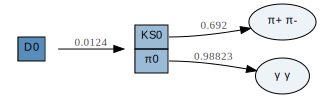

In [79]:
DecayChainViewer(dc.to_dict())